#**Tracking Mental Health Discussions During the COVID-19 Pandemic on social media**

By: Alaa Mohamed Ahmed-1201103256


Mohamed Mamoun-1211306306

## Section 1: Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from wordcloud import WordCloud, STOPWORDS

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

## Section 2: Load & Prepare Data

In [ ]:
# Load dataset
train_df = pd.read_csv("/content/Corona_NLP_train.csv", encoding='latin1')
test_df = pd.read_csv('/content/Corona_NLP_test.csv', encoding='latin1')


train_df['OriginalTweet'] = train_df['OriginalTweet'].astype(str).str.lower()
test_df['OriginalTweet'] = test_df['OriginalTweet'].astype(str).str.lower()

# Filter mental health tweets
keywords = [
    "anxiety", "stress", "mental health", "depression", "fear", "panic",
    "lonely", "isolation", "lockdown", "bored", "worry", "tired", "overwhelmed",
    "sad", "nervous", "afraid", "scared", "suicide", "helpline", "burnout", "alone"
]

train_df['is_mental_health'] = train_df['OriginalTweet'].apply(lambda x: any(k in x for k in keywords))
test_df['is_mental_health'] = test_df['OriginalTweet'].apply(lambda x: any(k in x for k in keywords))

# Filter the datasets
mental_train = train_df[train_df['is_mental_health']].copy()
mental_test = test_df[test_df['is_mental_health']].copy()

#Section 3:Preprocessing

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import string
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer

abbreviations = {
    "u": "you", "ur": "your", "r": "are", "btw": "by the way", "idk": "i do not know",
    "omg": "oh my god", "pls": "please", "plz": "please", "smh": "shaking my head"
}

def preprocess(text):
    # 1. Sentence Segmentation
    sentences = sent_tokenize(text)

    cleaned_tokens = []
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    for sent in sentences:
        # 2. Tokenization
        tokens = word_tokenize(sent)

        # 3. Case Folding
        tokens = [word.lower() for word in tokens]

        # 4. Punctuation Removal
        tokens = [word for word in tokens if word not in string.punctuation]

        # 5. Abbreviation Expansion
        tokens = [abbreviations.get(word, word) for word in tokens]

        # 6. Stop Word Removal
        tokens = [word for word in tokens if word not in stop_words]

        # 7. Stemming
        tokens = [stemmer.stem(word) for word in tokens]

        cleaned_tokens.extend(tokens)

    return " ".join(cleaned_tokens)

def extract_pos_tags(text):
    tokens = word_tokenize(text)
    return pos_tag(tokens)  # Returns list of (word, POS_tag)

In [ ]:
def simplify_sentiment(label):
    if label in ['Extremely Negative', 'Negative']:
        return 'Negative'
    elif label in ['Extremely Positive', 'Positive']:
        return 'Positive'
    else:
        return 'Neutral'

mental_train['Sentiment_3class'] = mental_train['Sentiment'].apply(simplify_sentiment)
mental_test['Sentiment_3class'] = mental_test['Sentiment'].apply(simplify_sentiment)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(mental_train['Sentiment_3class'])
y_test = label_encoder.transform(mental_test['Sentiment_3class'])

In [ ]:
import nltk
nltk.download('punkt_tab')

# Apply preprocessing
mental_train['cleaned_text'] = mental_train['OriginalTweet'].apply(preprocess)
mental_test['cleaned_text'] = mental_test['OriginalTweet'].apply(preprocess)

# Preview cleaned data
mental_train[['OriginalTweet', 'cleaned_text']].head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,OriginalTweet,cleaned_text
3,my food stock is not the only one which is emp...,food stock one empti ... pleas n't panic enoug...
4,"me, ready to go at supermarket during the #cov...",readi go supermarket covid19 outbreak 'm paran...
10,all month there hasn't been crowding in the su...,month n't crowd supermarket restaur howev redu...
12,#horningsea is a caring community. letâs all ...,horningsea care commun letâ look less capabl ...
24,@10downingstreet @grantshapps what is being do...,10downingstreet grantshapp done ensur food ess...


#Section4:TF-IDF Vectorization

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(mental_train['cleaned_text'])
X_test = vectorizer.transform(mental_test['cleaned_text'])


## Section 5: Traditional Machine Learning Models

In [ ]:

models = {
    'Logistic Regression': LogisticRegression(max_iter=300),
    'SVM': SVC(kernel='linear'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': MultinomialNB()
}

for name, model in models.items():
    print(f"\n{name} Report:")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))



Logistic Regression Report:
              precision    recall  f1-score   support

    Negative       0.75      0.92      0.83       602
     Neutral       0.44      0.09      0.15        80
    Positive       0.71      0.53      0.61       274

    accuracy                           0.74       956
   macro avg       0.63      0.51      0.53       956
weighted avg       0.71      0.74      0.71       956


SVM Report:
              precision    recall  f1-score   support

    Negative       0.76      0.90      0.83       602
     Neutral       0.50      0.15      0.23        80
    Positive       0.70      0.57      0.62       274

    accuracy                           0.74       956
   macro avg       0.65      0.54      0.56       956
weighted avg       0.72      0.74      0.72       956


Random Forest Report:
              precision    recall  f1-score   support

    Negative       0.68      0.96      0.80       602
     Neutral       0.59      0.12      0.21        80
    Positi

/tmp/ipython-input-36-306382338.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_scores.keys()), y=list(model_scores.values()), palette='viridis')


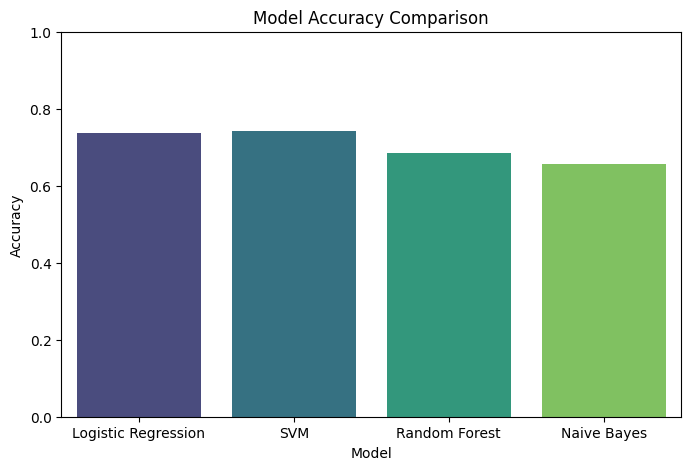

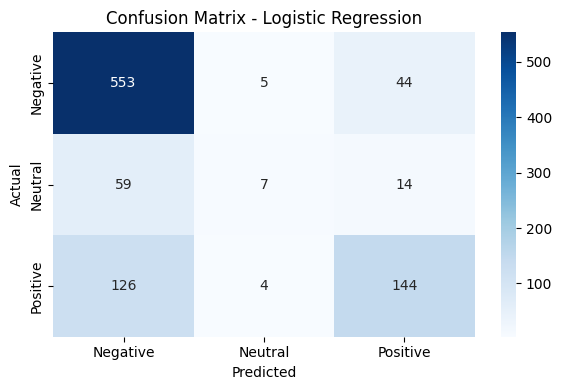

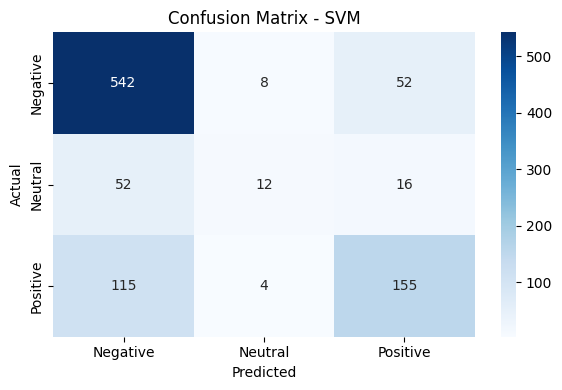

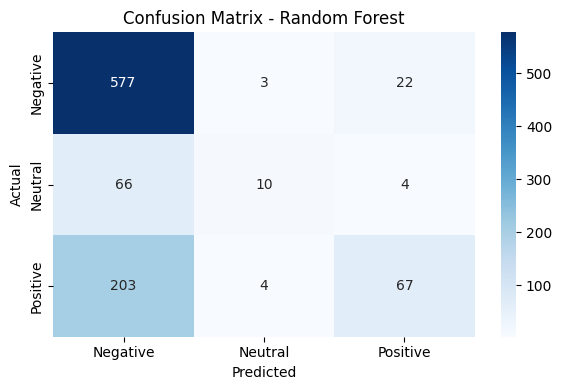

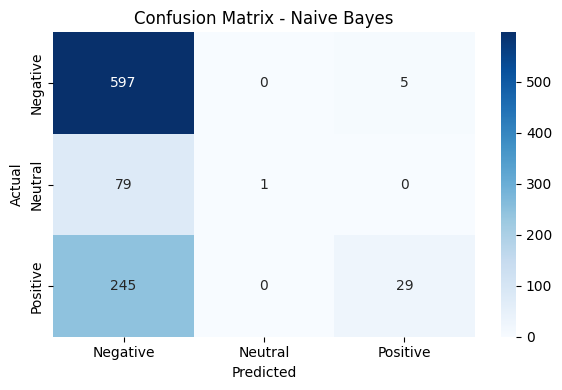

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# Store accuracy and confusion matrix
model_scores = {}
conf_matrices = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    model_scores[name] = acc
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

# Plot accuracy for each model
plt.figure(figsize=(8, 5))
sns.barplot(x=list(model_scores.keys()), y=list(model_scores.values()), palette='viridis')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.show()

# Plot confusion matrix heatmaps
for name, cm in conf_matrices.items():
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


#Section 6 :Visualizations

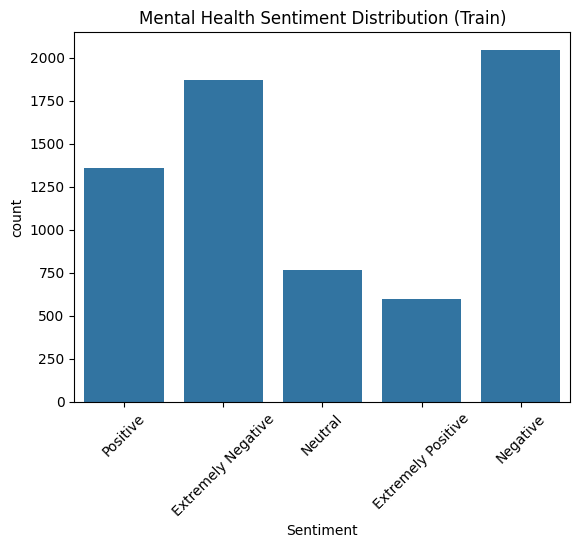

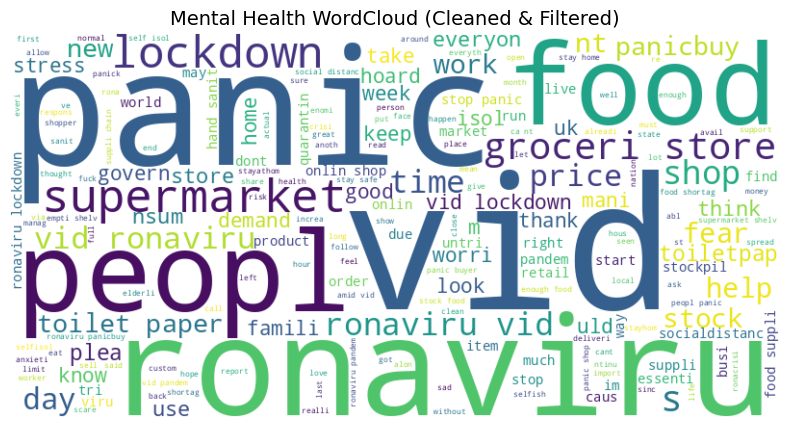

In [ ]:

sns.countplot(x='Sentiment', data=mental_train)
plt.title('Mental Health Sentiment Distribution (Train)')
plt.xticks(rotation=45)
plt.show()

import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Join all cleaned mental health tweets
text = ' '.join(mental_train['cleaned_text'])

# EXTRA cleaning: remove URL remnants and junk
text = re.sub(r"http\S+|www\S+|https|t\.co|&amp|co", '', text)
text = re.sub(r"[^a-zA-Z\s]", '', text)  # keep only letters and spaces

#  Add custom stopwords to remove generic/unhelpful terms
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    'people', 'make', 'buy', 'today', 'thing', 'get', 'go', 'say',
    'need', 'see', 'amp', 'us', 'like', 'want', 'even', 'still',
    'many', 'one', 'everyone'
])

# Generate WordCloud with custom stopwords
wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    stopwords=custom_stopwords
).generate(text)

# Display the result
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Mental Health WordCloud (Cleaned & Filtered)", fontsize=14)
plt.show()



[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


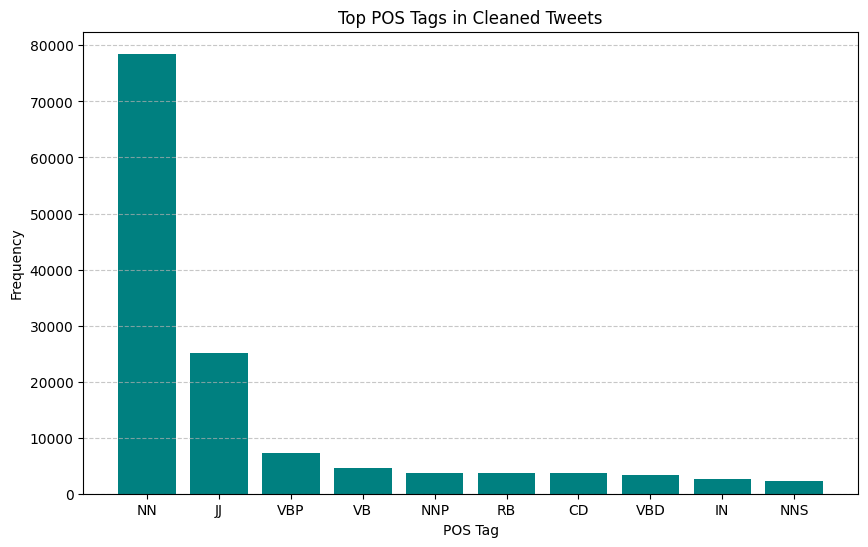

In [ ]:
import matplotlib.pyplot as plt
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk

# Download the specific English POS tagger resource
nltk.download('averaged_perceptron_tagger_eng')


# Combine all cleaned tweets into one large text
all_words = ' '.join(mental_train['cleaned_text'])

# Tokenize and get POS tags
tokens = word_tokenize(all_words)
pos_tags = [tag for word, tag in pos_tag(tokens)]

# Count POS tags
pos_counts = Counter(pos_tags)

# Plot the most common POS tags
top_n = 10  # Number of POS tags to display
most_common_pos = pos_counts.most_common(top_n)

# Convert to bar chart
tags, counts = zip(*most_common_pos)
plt.figure(figsize=(10,6))
plt.bar(tags, counts, color='teal')
plt.title('Top POS Tags in Cleaned Tweets')
plt.xlabel('POS Tag')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Section 7 :k-Fold Cross-Validation for Machine Learning Models

In [ ]:


from sklearn.model_selection import cross_val_score, StratifiedKFold

# Use 5-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(max_iter=300),
    'SVM': SVC(kernel='linear'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': MultinomialNB()
}

for name, model in models.items():
    print(f"\n{name} - 5-Fold Cross Validation")
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    print(f"Accuracy scores: {scores}")
    print(f"Mean Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")



Logistic Regression - 5-Fold Cross Validation
Accuracy scores: [0.72569706 0.73926149 0.74378297 0.72624434 0.73303167]
Mean Accuracy: 0.7336 ± 0.0071

SVM - 5-Fold Cross Validation
Accuracy scores: [0.72192916 0.72569706 0.73624717 0.7254902  0.73529412]
Mean Accuracy: 0.7289 ± 0.0058

Random Forest - 5-Fold Cross Validation
Accuracy scores: [0.69178598 0.67972871 0.69706104 0.70286576 0.67496229]
Mean Accuracy: 0.6893 ± 0.0105

Naive Bayes - 5-Fold Cross Validation
Accuracy scores: [0.63451394 0.63149962 0.64883195 0.64328808 0.62820513]
Mean Accuracy: 0.6373 ± 0.0077


#Section 8:GridSearchCV for SVM Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Define smaller parameter grid
param_grid = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf']
}

# Initialize base model
svm_model = SVC()

# Apply grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,  # Reduced from 5 to 3 for speed
    verbose=1,
    n_jobs=-1
)

# Run the search
grid_search.fit(X_train, y_train)

# Show best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Evaluate on test set
best_svm_model = grid_search.best_estimator_
y_pred = best_svm_model.predict(X_test)

# Show classification report
print("Classification Report with Best Parameters:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'C': 1, 'kernel': 'linear'}
Best Cross-Validation Accuracy: 0.6927
Classification Report with Best Parameters:
              precision    recall  f1-score   support

    Negative       0.76      0.90      0.83       602
     Neutral       0.50      0.15      0.23        80
    Positive       0.70      0.57      0.62       274

    accuracy                           0.74       956
   macro avg       0.65      0.54      0.56       956
weighted avg       0.72      0.74      0.72       956



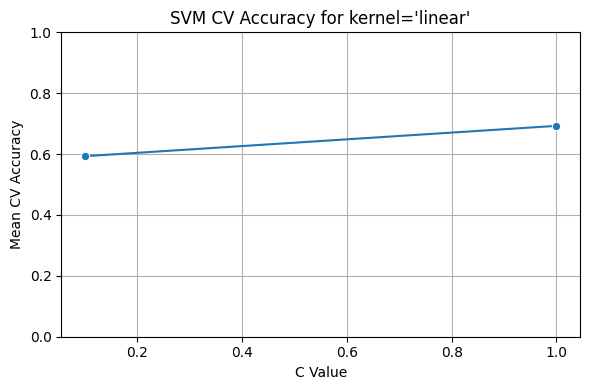

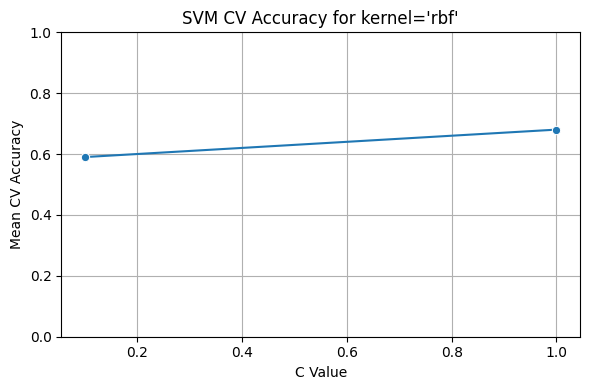

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert GridSearchCV results to DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Plot accuracy for each kernel and C value
for kernel in results_df['param_kernel'].unique():
    subset = results_df[results_df['param_kernel'] == kernel]

    plt.figure(figsize=(6, 4))
    sns.lineplot(data=subset, x='param_C', y='mean_test_score', marker='o')
    plt.title(f"SVM CV Accuracy for kernel='{kernel}'")
    plt.xlabel("C Value")
    plt.ylabel("Mean CV Accuracy")
    plt.ylim(0.0, 1.0)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
